In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from pandas.api.types import is_string_dtype
from pandas.api.types import is_categorical_dtype

In [20]:
def pre_processing(credit):
	# preprocessing - convert data type and dummy coding
	cols = credit.columns
	isCat_Index = list()
	for col in cols:
		if is_string_dtype(credit[col]):
			credit[col] = credit[col].astype('category')
		isCat_Index.append(is_categorical_dtype(credit[col]))
	
	credit_d = pd.get_dummies(credit, columns=list(cols[isCat_Index]))
	print(credit_d.shape)
	return credit_d

In [21]:
SEED = 166

# preprocessing: scaling the data and split dataset
data = pd.read_csv("../credit.csv")
data = pre_processing(data)
predictors = data[data.columns.difference(["default"])]
scaler = MinMaxScaler()
predictors_scaled = scaler.fit_transform(predictors)
target = data[["default"]].values.ravel()

train_X, test_X, train_y, test_y = train_test_split(predictors_scaled, target, train_size=0.8, random_state=SEED, stratify=target)

# in clustering experiments, only use training set
data, label = train_X, train_y

(1000, 62)


In [22]:
reconstructionErrors = []
maxComponents = 61
minComponents = 1
for i in range(minComponents, maxComponents+1):
    pca = PCA(n_components=i, random_state=SEED)
    data_transform = pca.fit_transform(data)
    data_inverse = pca.inverse_transform(data_transform)
    mse = np.sum(np.square(data - data_inverse))/data_inverse.size
    
    reconstructionErrors.append(mse)

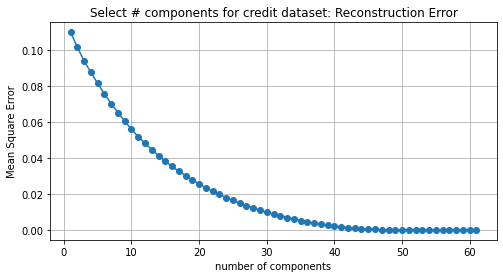

In [23]:
plt.figure(figsize=(8,4))
plt.plot(range(minComponents, maxComponents+1), reconstructionErrors,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('Mean Square Error')
plt.title('Select # components for credit dataset: Reconstruction Error')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\pca_credit_error.png', dpi=300)
plt.show()

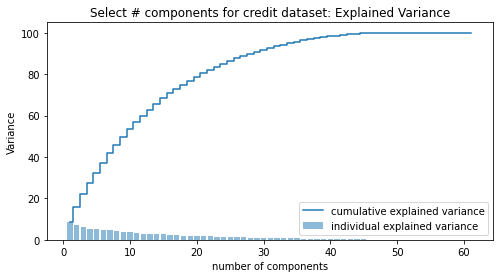

In [24]:
pca = PCA(n_components=maxComponents, random_state=SEED)
pca.fit(data)
# print(pca.explained_variance_ratio_)

tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# print(cum_var_exp)

plt.figure(figsize=(8,4))
plt.bar(range(minComponents, maxComponents+1), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(minComponents, maxComponents+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.xlabel('number of components')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.title('Select # components for credit dataset: Explained Variance')
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\pca_credit_variance.png', dpi=300)

plt.show()

(1000, 62)
Misclassified samples: 57
SVM Kernel train/test accuracy: 0.799/0.715


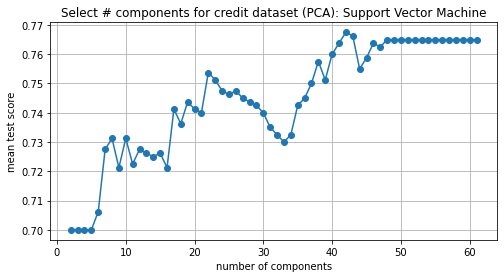

In [25]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

######
# Run Grid Search to find optimal components
######
# import packages
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

SEED = 77
# preprocessing: scaling the data and split dataset
data = pd.read_csv("../credit.csv")
data = pre_processing(data)
predictors = data[data.columns.difference(["default"])]

target = data[["default"]].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=0.8, random_state=SEED, stratify=target)
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_toTransform = X_train_std
y_train = y_train
y_test = y_test

# Define the classifier
svm = SVC(random_state=1, kernel='linear', gamma=0.1, C=10)
pipe = Pipeline([
    ('reduce_dim', PCA())
     ,('classify', svm)
])
N_FEATURES_OPTIONS = range(2,62)
parameters = {  'reduce_dim__n_components':N_FEATURES_OPTIONS,
             }
clf = GridSearchCV(pipe, cv=5, param_grid=parameters, n_jobs=-1)

# Run the classifier
clf.fit(X_train_std, y_train)

# Identify training and test accuracy
y_pred = clf.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('SVM Kernel train/test accuracy: %.3f/%.3f' % (train_accuracy, test_accuracy))

mean_scores = np.array(clf.cv_results_['mean_test_score'])

mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (1 + 1) + .5)

scores = [x for x in clf.cv_results_['mean_test_score']]

plt.figure(figsize=(8,4))
plt.plot(N_FEATURES_OPTIONS, scores,'-o')
# plt.xticks(k_grid)
plt.xlabel('number of components')
plt.ylabel('mean test score')
plt.title('Select # components for credit dataset (PCA): Support Vector Machine')
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\pca_credit_svm.png', dpi=300)
plt.show()